In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import electrode2currentmap as e2cm
import effectivecurrent2brightness as ec2b
from utils import TimeSeries
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
r = e2cm.Retina(axon_map='../SmallRetina.npz', 
                sampling=25, xlo=-600, xhi=600, ylo=-600, yhi=600)
                

In [4]:
# Create electrode array 
# covers 10.32 dva (6 electrodes) by 17.2 (10 electrodes) dva. 
# 293 μm equals 1 degree
# electrode spacing is done in microns

xlist=[]
ylist=[]
rlist=[]
e_spacing=525
#DEBUG
#for x in np.arange(-1312, 1313, e_spacing):
#    for y in np.arange(-2362, 2364, e_spacing):    
for x in np.arange(-525, 526, e_spacing):
    for y in np.arange(-525, 526, e_spacing):  
        xlist.append(x)
        ylist.append(y)
        rlist.append(100)        

e_all = e2cm.ElectrodeArray(rlist,xlist,ylist)

e_rf=[]
e_spacing=550
for e in e_all.electrodes:
    e_rf.append(e2cm.receptive_field(e, r.gridx, r.gridy,e_spacing))

In [5]:
# create movie
#degscreen=[52.74, 63.32] # screen visual angle
#res=[768 ,1024] # resolution of screen
#pixperdeg=degscreen/res
degscreen=[10.32, 17.2] # array visual angle, no need to simulate the whole movie
res=[e_rf[0].shape[0],e_rf[1].shape[1]] # resolution of screen

fps=30

[X,Y]=np.meshgrid(np.linspace(-degscreen[1]/2, degscreen[1]/2, res[1]), 
np.linspace(-degscreen[0]/2, degscreen[0]/2, res[0]));

In [6]:
for o in np.arange(np.pi/180, 360*np.pi/180): # each orientation
    M=np.cos(o)*X +np.sin(o)*Y

 #   for sp in range (32:32): # DEBUG each speed, eventually 8:32  
    sp=8
    movie=np.zeros((res[0],res[1], int(np.ceil((70/5)*30))))
    st=np.min(M)
    fm_ct=1
    while (st<np.max(M)):
        img=np.zeros(M.shape)
        ind=np.where((M>st) & (M<st+6.7))
        img[ind]=1    
        movie[:,:, fm_ct]=img
        fm_ct=fm_ct+1
        st=st+(sp/fps)   
         
    movie=movie[:,:, 0:fm_ct-1]   
    
    pt=[]
    for rf in e_rf:
        rflum= e2cm.retinalmovie2electrodtimeseries(rf, movie) 
        pt.append(e2cm.Movie2Pulsetrain(rflum)) 
    
          
    ecs_list = r.electrode_ecs(e_all)        
    tm1 = ec2b.TemporalModel()
    #fr=np.zeros([e_rf[0].shape[0],e_rf[0].shape[1], len(pt[0].data)])
    brightnessmovie = np.zeros(r.gridx.shape + (22176,))
    #DEBUG for xx in range(ecm.shape[0]):
    #    for yy in range(ecm.shape[1]):
    for xx in range(r.gridx.shape[0]):
        for yy in range(r.gridx.shape[1]):
            ecm = r.ecm(xx, yy, ecs_list, pt)
            fr = tm1.fast_response(ecm, dojit=True)    
            ca = tm1.charge_accumulation(fr, ecm)
            sn = tm1.stationary_nonlinearity(ca)
            sr = tm1.slow_response(sn)
            sr.resample(25)
            brightnessmovie[xx, yy, :] = sr.data
    boom    
    

NameError: name 'boom' is not defined

In [12]:
np.save('/home/ubuntu/movie20160218.npy', brightnessmovie)

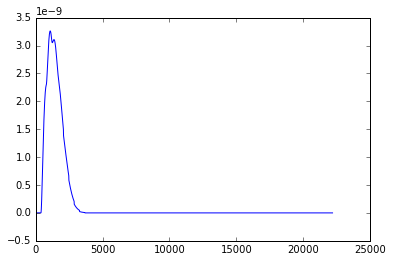

In [8]:
plt.plot(brightnessmovie[24, 24])

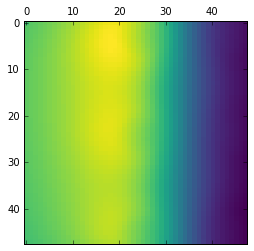

In [9]:
plt.matshow(brightnessmovie[:, :, 2000], cmap='viridis')

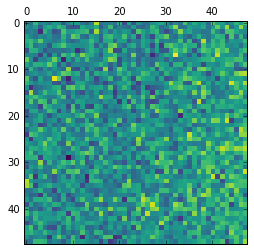

In [11]:
plt.matshow(brightnessmovie[:, :, 4000], cmap='viridis')